# using gradient boosted decision trees as a meta-classifier

In [384]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr',
    'caret'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "caret"        "lattice"      "stringr"      "pROC"         "tidyr"       
 [6] "dplyr"        "glmnet"       "foreach"      "Matrix"       "xgboost"     
[11] "ggplot2"      "RColorBrewer" "stats"        "graphics"     "grDevices"   
[16] "utils"        "datasets"     "methods"      "base"

In [3]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

In [380]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- as.numeric(sum( predicted_classes[pos] == true_classes[pos] ))
    TN <- as.numeric(sum( predicted_classes[neg] == true_classes[neg] ))
    FP <- as.numeric(sum( predicted_classes[pos] != true_classes[pos] ))
    FN <- as.numeric(sum( predicted_classes[neg] != true_classes[neg] )) 
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        M <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

In [417]:
ggplotColours <- function(n = 6, h = c(0, 360) + 15){
  if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
  hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
} 

## Load data

In [4]:
# paul's data frame

tableName <- "ftClean.Fri.Sep.30.2016-18:02:21.RData"
directory <- "~/git-repos/BDDS/trenadb/featureTable/lymphoblast"
fullPath <- file.path(directory, tableName)
stopifnot(file.exists(fullPath))
load(fullPath)

# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

In [5]:
str(ft.clean)

'data.frame':	96825 obs. of  11 variables:
 $ loc             : chr  "chr19:42000006-42000014" "chr19:42000007-42000019" "chr19:42000008-42000019" "chr19:42000009-42000018" ...
 $ motif           : chr  "MA0738.1" "MA0872.1" "LMO2.p2" "MA0522.2" ...
 $ samplecount.w   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ score.w         : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ samplecount.h   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ score.h         : num  16 16 16 16 16 16 16 16 16 16 ...
 $ csTF            : chr  NA NA NA NA ...
 $ csscore         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ motifscore      : num  11.2 10.2 10.3 12.2 11.7 ...
 $ motifpval       : num  6.51e-05 7.15e-05 5.84e-05 7.11e-05 5.93e-05 5.65e-05 6.02e-05 2.92e-05 6.78e-05 8.34e-05 ...
 $ totalsamplecount: num  18 18 18 18 18 18 18 18 18 18 ...


In [254]:
head((ft.clean))

loc,motif,samplecount.w,score.w,samplecount.h,score.h,csTF,csscore,motifscore,motifpval,totalsamplecount
chr19:42000006-42000014,MA0738.1,0,-99,1,16,NA,0,11.1636,6.51e-05,18
chr19:42000007-42000019,MA0872.1,0,-99,1,16,NA,0,10.1967,7.15e-05,18
chr19:42000008-42000019,LMO2.p2,0,-99,1,16,NA,0,10.3421,5.84e-05,18
chr19:42000009-42000018,MA0522.2,0,-99,1,16,NA,0,12.2308,7.11e-05,18
chr19:42000009-42000018,MA0820.1,0,-99,1,16,NA,0,11.7414,5.93e-05,18
chr19:42000009-42000018,MA0830.1,0,-99,1,16,NA,0,12.5510,5.65e-05,18


In [252]:
head(tf.fams.table)

ID,class,family
MA0151.1,ARID domain factors,ARID-related factors
MA0601.1,ARID domain factors,ARID-related factors
MA0602.1,ARID domain factors,ARID-related factors
MA0004.1,Basic helix-loop-helix factors (bHLH),PAS domain factors
MA0048.2,Basic helix-loop-helix factors (bHLH),Tal-related factors
MA0058.3,Basic helix-loop-helix factors (bHLH),bHLH-ZIP factors


## add tf classes as features

In [8]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(ft.clean$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [9]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for

ft.clean.corymotifs <- ft.clean %>% filter(motif %in% from.paul.in.cory)
str(ft.clean.corymotifs)

'data.frame':	76891 obs. of  11 variables:
 $ loc             : chr  "chr19:42000006-42000014" "chr19:42000007-42000019" "chr19:42000009-42000018" "chr19:42000009-42000018" ...
 $ motif           : chr  "MA0738.1" "MA0872.1" "MA0522.2" "MA0820.1" ...
 $ samplecount.w   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ score.w         : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ samplecount.h   : num  1 1 1 1 1 1 1 1 1 1 ...
 $ score.h         : num  16 16 16 16 16 16 16 16 16 16 ...
 $ csTF            : chr  NA NA NA NA ...
 $ csscore         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ motifscore      : num  11.2 10.2 12.2 11.7 12.6 ...
 $ motifpval       : num  6.51e-05 7.15e-05 7.11e-05 5.93e-05 5.65e-05 2.92e-05 6.78e-05 8.34e-05 2.67e-05 5.65e-05 ...
 $ totalsamplecount: num  18 18 18 18 18 18 18 18 18 18 ...


In [10]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [11]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [271]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [274]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510  30

[1] 513

character(0)

In [14]:
# tf class distribution
colSums(tf.motif.class.matrix)

ARIDdomainfactors   Basichelix-loop-helixfactors(bHLH) 
                                   2                                   62 
  Basichelix-span-helixfactors(bHSH)      Basicleucinezipperfactors(bZIP) 
                                   9                                   43 
      C2CHTHAP-typezincfingerfactors                C2H2zincfingerfactors 
                                   1                                   56 
                           CRCdomain  DM-typeintertwinedzincfingerfactors 
                                   1                                    1 
         Forkhead/wingedhelixfactors                     GCMdomainfactors 
                                  36                                    2 
             Grainyheaddomainfactors                     Heatshockfactors 
                                   2                                    3 
     HeteromericCCAAT-bindingfactors High-mobilitygroup(HMG)domainfactors 
                                   2                                   13 
                  Homeodomainfactors                       MADSboxfactors 
                                 145                                    5 
   NuclearreceptorswithC4zincfingers        OtherC4zincfinger-typefactors 
                                  36                                    6 
                    p53domainfactors                     Pairedboxfactors 
                                   3                                    8 
                   Psq-typeHTHdomain        Relhomologyregion(RHR)factors 
                                   1                                    9 
                   Runtdomainfactors                    SANDdomainfactors 
                                   3                                    2 
   SMAD/NF-1DNA-bindingdomainfactors                    STATdomainfactors 
                                   5                                    6 
                        T-Boxfactors                 TATA-bindingproteins 
                                  12                                    1 
                    TEAdomainfactors             Tryptophanclusterfactors 
                                   4                                   34

In [310]:
# merging is a way saner way to... merge dataframes, who knew?
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)
dim(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 510  31

[1] 76891    41

In [308]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [418]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 76891

[1] 77193

## Split data into feature matrix and output

In [419]:
y <- as.numeric(ft.clean.corymotifs.tfclasses$csscore > 0)

In [420]:
cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")
X <- ft.clean.corymotifs.tfclasses[,!(colnames(ft.clean.corymotifs.tfclasses) %in% cols.to.drop)]

In [421]:
t(X[1:3,])

,1,2,3
samplecount.w,2.00000e+00,1.0000000,1.0000000
score.w,-1.32553e+01,-10.4256000,-18.7025000
samplecount.h,8.00000e+00,0.0000000,3.0000000
score.h,8.58000e+02,0.0000000,57.0000000
motifscore,1.51207e+01,11.4483000,13.0690000
motifpval,7.04000e-07,0.0000604,0.0000152
ARIDdomainfactors,0.00000e+00,0.0000000,0.0000000
Basichelix-loop-helixfactors(bHLH),0.00000e+00,0.0000000,0.0000000
Basichelix-span-helixfactors(bHSH),0.00000e+00,0.0000000,0.0000000
Basicleucinezipperfactors(bZIP),0.00000e+00,0.0000000,0.0000000


In [22]:
train.inds <- split_data(y)

X.train <- X[train.inds,]
X.test <- X[-train.inds,]
y.train <- y[train.inds]
y.test <- y[-train.inds]

In [239]:
str(as.matrix(X.train))
str(y)
mean(y)

 num [1:57668, 1:36] 0 0 0 1 0 0 0 0 0 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:57668] "52108" "1372" "15102" "21518" ...
  ..$ : chr [1:36] "samplecount.w" "score.w" "samplecount.h" "score.h" ...
 num [1:76891] 0 0 0 0 0 0 0 0 0 0 ...


[1] 0.139158

In [242]:
param <- list("objective" = "binary:logistic",
              "max.depth" = 10,
              "eta" = 0.001,
              "eval.metric" = "auc"
#               "scale_pos_weight" = 1 - mean(y)
              )

gbdt <- xgboost(
    params = param,
    data = as.matrix(X.train),
    label = y.train,
    nround = 1000,
    verbose = FALSE,
    missing = NA
)

[0]	train-auc:0.910727
[1]	train-auc:0.910742
[2]	train-auc:0.910712
[3]	train-auc:0.910706
[4]	train-auc:0.910690
[5]	train-auc:0.910689
[6]	train-auc:0.910668
[7]	train-auc:0.910671
[8]	train-auc:0.910658
[9]	train-auc:0.910665
[10]	train-auc:0.910651
[11]	train-auc:0.910660
[12]	train-auc:0.910655
[13]	train-auc:0.910660
[14]	train-auc:0.910655
[15]	train-auc:0.911863
[16]	train-auc:0.911814
[17]	train-auc:0.912065
[18]	train-auc:0.912232
[19]	train-auc:0.912298
[20]	train-auc:0.912376
[21]	train-auc:0.912420
[22]	train-auc:0.912521
[23]	train-auc:0.912555
[24]	train-auc:0.912529
[25]	train-auc:0.912544
[26]	train-auc:0.912569
[27]	train-auc:0.912586
[28]	train-auc:0.912617
[29]	train-auc:0.912637
[30]	train-auc:0.912638
[31]	train-auc:0.912683
[32]	train-auc:0.912719
[33]	train-auc:0.912759
[34]	train-auc:0.912767
[35]	train-auc:0.912789
[36]	train-auc:0.912801
[37]	train-auc:0.912805
[38]	train-auc:0.912808
[39]	train-auc:0.912869
[40]	train-auc:0.912844
[41]	train-auc:0.912855
[4

In [382]:
preds.holdout <- predict(gbdt,as.matrix(X.test), missing=NA)
preds.overfit <- predict(gbdt,as.matrix(X.train), missing=NA)

mean(round(preds.holdout) == y.test)
mean(round(preds.overfit) == y.train)
mattcc(round(preds.holdout),y.test)
mattcc(round(preds.overfit),y.train)

[1] 0.9252458

[1] 0.9330998

[1] 0.6476798

[1] 0.6945262


Call:
roc.default(response = y.test, predictor = preds.holdout)

Data: preds.holdout in 16590 controls (y.test 0) < 2633 cases (y.test 1).
Area under the curve: 0.9139

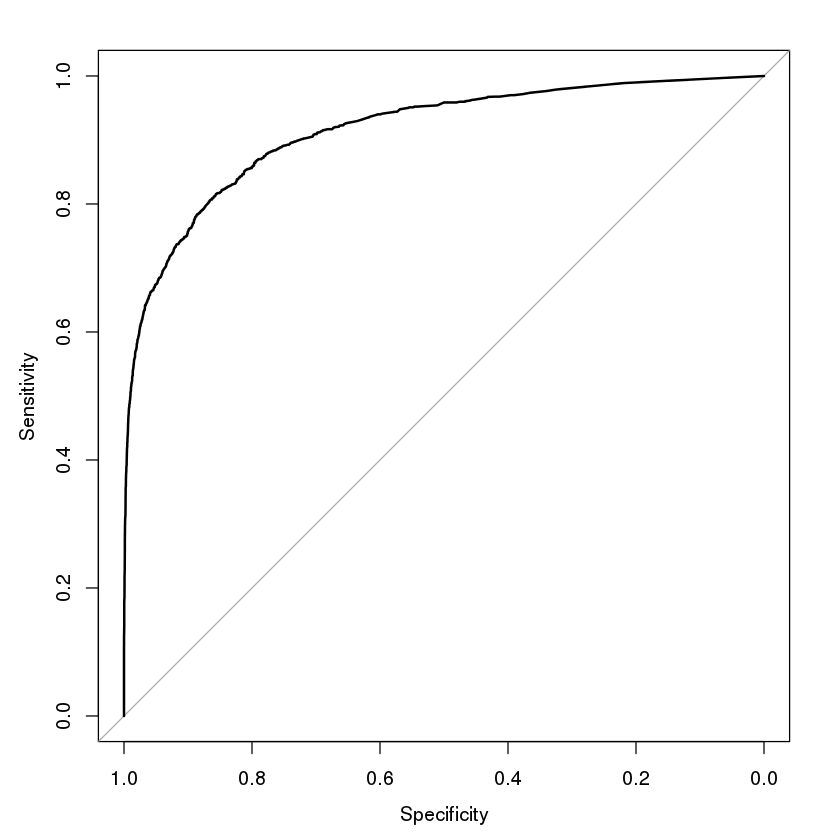

In [416]:
roc.motifs <- roc(y.test, preds.holdout)
plot(roc.motifs)

In [385]:
str(y.test)
str(round(preds.holdout.nonames))

 num [1:19223] 0 0 0 0 0 0 0 0 0 0 ...
 num [1:19223] 0 0 0 0 0 0 0 0 0 0 ...


In [396]:
preds.holdout.nonames <- preds.holdout
names(preds.holdout.nonames) <- NULL

mattcc(y.test,round(preds.holdout.nonames))

[1] 0.6476798

In [397]:
confusionMatrix(round(preds.holdout.nonames), y.test, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 16335  1182
         1   255  1451
                                          
               Accuracy : 0.9252          
                 95% CI : (0.9214, 0.9289)
    No Information Rate : 0.863           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6288          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.55108         
            Specificity : 0.98463         
         Pos Pred Value : 0.85053         
         Neg Pred Value : 0.93252         
             Prevalence : 0.13697         
         Detection Rate : 0.07548         
   Detection Prevalence : 0.08875         
      Balanced Accuracy : 0.76786         
                                          
       'Positive' Class : 1               
                                          

In [245]:
importance_matrix <- xgb.importance(colnames(X),model=gbdt)

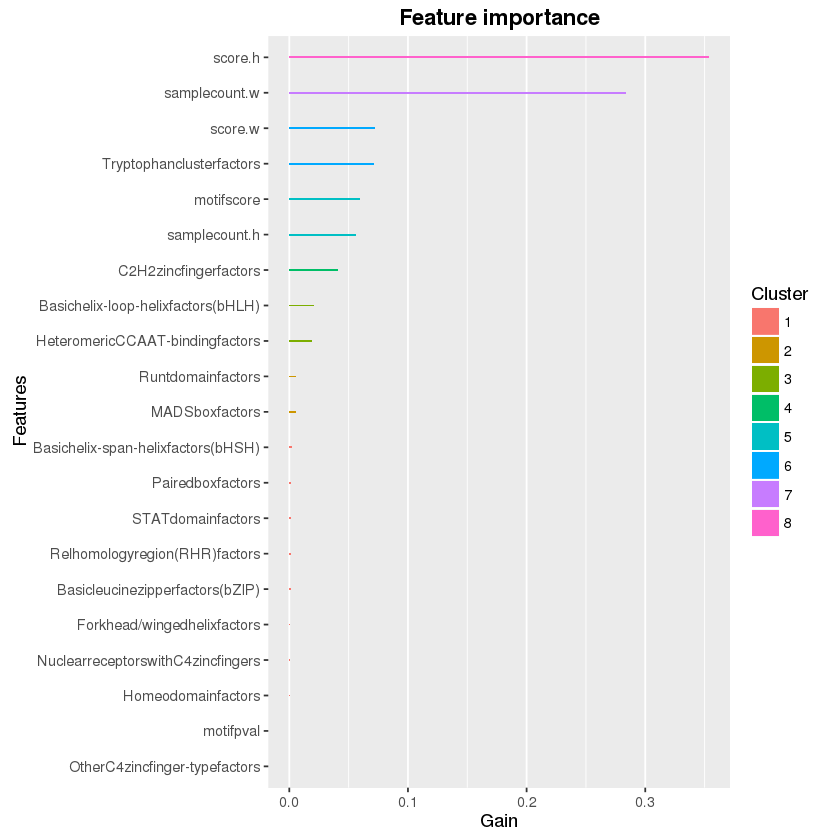

In [246]:
xgb.plot.importance(importance_matrix)

## no TF class info

In [142]:
no.tf.class.cols <- !(colnames(X.train) %in% colnames(tf.motif.class.matrix))
X.train.no.tf.class <- scale(X.train[,no.tf.class.cols])
X.test.no.tf.class <- scale(X.test[,no.tf.class.cols])

In [140]:
param <- list("objective" = "binary:logistic",
              "max.depth" = 10,
              "eta" = 0.001,
              "eval.metric" = "auc"
              )

gbdt.no.tf.class <- xgboost(
    params = param,
    data = as.matrix(X.train.no.tf.class),
    label = y.train,
    nround = 1000,
    verbose = FALSE,
    missing = NA
)

[0]	train-auc:0.881774
[1]	train-auc:0.881855
[2]	train-auc:0.881808
[3]	train-auc:0.881842
[4]	train-auc:0.881786
[5]	train-auc:0.881795
[6]	train-auc:0.881763
[7]	train-auc:0.881751
[8]	train-auc:0.881715
[9]	train-auc:0.881698
[10]	train-auc:0.881676
[11]	train-auc:0.881681
[12]	train-auc:0.881667
[13]	train-auc:0.881670
[14]	train-auc:0.881654
[15]	train-auc:0.881747
[16]	train-auc:0.881754
[17]	train-auc:0.881792
[18]	train-auc:0.881797
[19]	train-auc:0.881809
[20]	train-auc:0.881866
[21]	train-auc:0.881874
[22]	train-auc:0.881890
[23]	train-auc:0.881892
[24]	train-auc:0.882134
[25]	train-auc:0.882122
[26]	train-auc:0.882193
[27]	train-auc:0.882190
[28]	train-auc:0.882213
[29]	train-auc:0.882271
[30]	train-auc:0.882282
[31]	train-auc:0.882302
[32]	train-auc:0.882368
[33]	train-auc:0.882364
[34]	train-auc:0.882385
[35]	train-auc:0.882393
[36]	train-auc:0.882428
[37]	train-auc:0.882488
[38]	train-auc:0.882502
[39]	train-auc:0.882521
[40]	train-auc:0.882541
[41]	train-auc:0.882548
[4

In [144]:
preds.no.tf.class.holdout <- predict(gbdt,as.matrix(X.test.no.tf.class), missing=NA)
preds.no.tf.class.overfit <- predict(gbdt,as.matrix(X.train.no.tf.class), missing=NA)

mean(round(preds.no.tf.class.holdout) == y.test)
mean(round(preds.no.tf.class.overfit) == y.train)

[1] 0.8995474

[1] 0.9166089


Call:
roc.default(response = y.test, predictor = preds.no.tf.class.holdout)

Data: preds.no.tf.class.holdout in 16590 controls (y.test 0) < 2633 cases (y.test 1).
Area under the curve: 0.8681

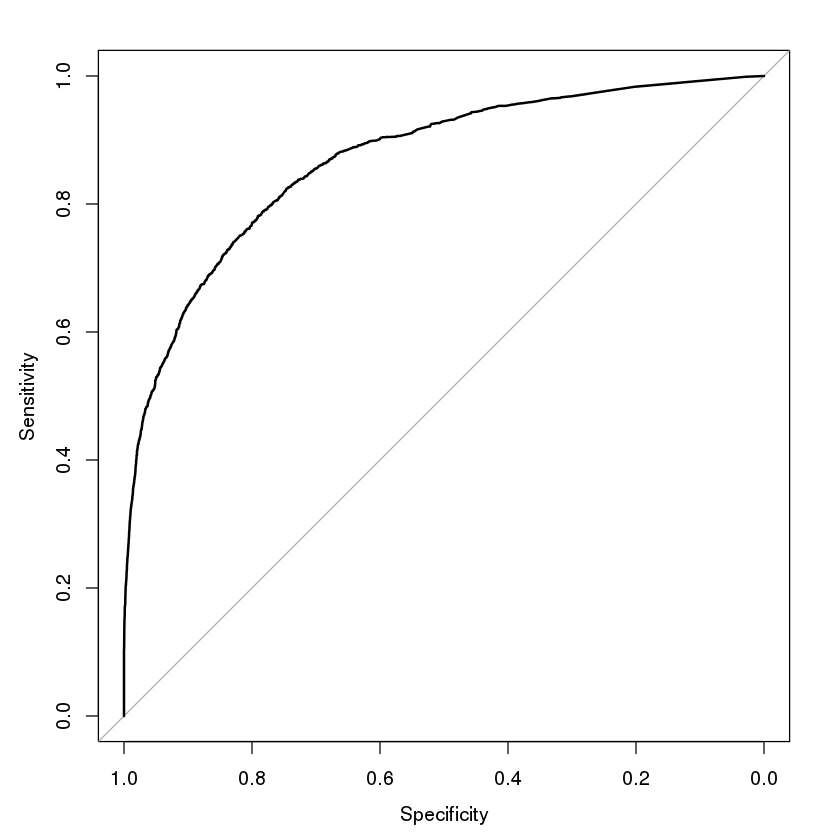

In [145]:
roc.motifs.no.tf.class <- roc(y.test, preds.no.tf.class.holdout)
plot(roc.motifs.no.tf.class)

In [398]:
confusionMatrix(round(preds.no.tf.class.holdout), y.test, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 16324  1665
         1   266   968
                                          
               Accuracy : 0.8995          
                 95% CI : (0.8952, 0.9038)
    No Information Rate : 0.863           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4528          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.36764         
            Specificity : 0.98397         
         Pos Pred Value : 0.78444         
         Neg Pred Value : 0.90744         
             Prevalence : 0.13697         
         Detection Rate : 0.05036         
   Detection Prevalence : 0.06419         
      Balanced Accuracy : 0.67580         
                                          
       'Positive' Class : 1               
                                          

In [146]:
importance_matrix.no.tf.class <- xgb.importance(colnames(X.test.no.tf.class),model=gbdt.no.tf.class)

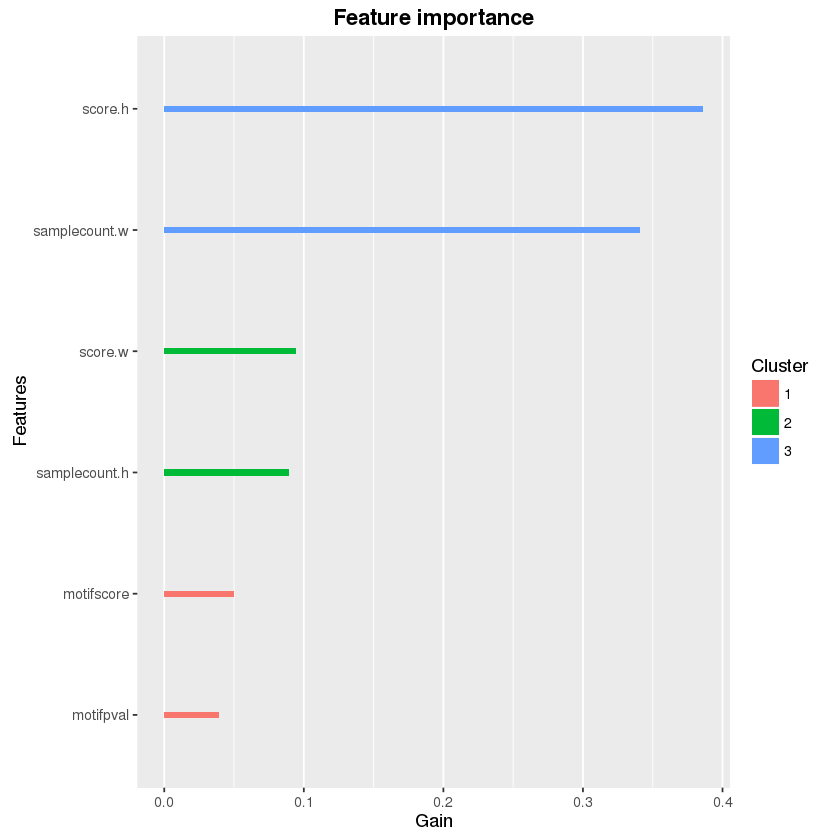

In [147]:
xgb.plot.importance(importance_matrix.no.tf.class)